In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from tqdm.autonotebook import tqdm
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

/home/nandan/.local/share/virtualenvs/ModelInformedRL-v_iDpmFY/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
from tensorboardX import SummaryWriter
writer = SummaryWriter('runs/kin-kin/basic-bicycle-batched')

In [3]:
train_frame = pd.read_pickle("../../data/train_data.pkl")
test_frame = pd.read_pickle("../../data/test_data.pkl")
#train_frame = train_frame.iloc[-1:]; test_frame = train_frame;

In [4]:
class TraceDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        input = torch.tensor(train_frame.iloc[idx]['input'], dtype=torch.float32)
        target = torch.tensor(train_frame.iloc[idx]['target'], dtype=torch.float32)
        return input, target

train_dataset = TraceDataset(train_frame)
test_dataset = TraceDataset(test_frame)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
def bicycle_model_eval(inputs, last_poses):
    # This version takes in an input of dim 5
    BATCHES = inputs.shape[0]
    states = []  # torch.zeros((81, 4))
    L = 0.3302
    TS = 0.1
    X, Y, THETA, V = 0, 1, 2, 3
    state = torch.zeros((BATCHES, 4,))
    state[:,X] = last_poses[:,0]
    state[:,Y] = last_poses[:,1]
    state[:,THETA] = last_poses[:,2]
    state[:,V] = inputs[:,0]
    states.append(state)
    for i in range(1,81):
        # Advance bicycle model
        state = torch.zeros((BATCHES, 4,))
        state[:,X] = states[i-1][:,X] + (TS * states[i-1][:,V] * torch.cos(states[i-1][:,THETA]))
        state[:,Y] = states[i-1][:,Y] + (TS * states[i-1][:,V] * torch.sin(states[i-1][:,THETA]))
        state[:,THETA] = states[i-1][:,THETA] + (TS * (states[i-1][:,V] * torch.tan(inputs[:,1])) / L)
        state[:,V] = states[i-1][:,V] + TS*inputs[:,2]
        states.append(state)
    trace = torch.dstack(states).movedim((0,1,2), (0,2,1))
    trace = trace[:,1:,:3]
    return trace

def custom_loss_func(prediction, target):
    loss = F.mse_loss(prediction, target)
    #loss += 10*output[0]**2 if output[0]<0 else 0
    #loss += 2*torch.linalg.norm(output)**2
    return loss

class LSTMPredictorBicycle(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=10, control_outputs=1):
        super(LSTMPredictorBicycle, self).__init__()
        self.hidden_dim = hidden_dim
        self.control_outputs = control_outputs

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, 1+control_outputs*2)
        )

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        output = self.hidden2output(lstm_out)
        output = torch.dstack([F.softplus(output[:,:,0]), torch.tanh(output[:,:,1])*np.pi, output[:,:,2]])
        return output
    
    def predict(self, inputs, horizon=80):
        # Compute LSTM output
        controls = self.forward(inputs)[:,-1]  # Take last prediction
        last_poses = inputs[:,-1]  # Add last pose as input variable
        BATCHES = controls.shape[0]
        states = []  # torch.zeros((81, 4))
        L = 0.3302
        TS = 0.1
        X, Y, THETA, V = 0, 1, 2, 3
        CDIMS = 2
        state = torch.zeros((BATCHES, 4,), device=DEVICE)
        state[:,X] = last_poses[:,0]
        state[:,Y] = last_poses[:,1]
        state[:,THETA] = last_poses[:,2]
        state[:,V] = controls[:,0]
        states.append(state)
        steps = horizon//self.control_outputs
        for i in range(1,horizon+1):
            # Advance bicycle model
            step = (i-1)//horizon
            state = torch.zeros((BATCHES, 4,), device=DEVICE)
            state[:,X] = states[i-1][:,X] + (TS * states[i-1][:,V] * torch.cos(states[i-1][:,THETA]))
            state[:,Y] = states[i-1][:,Y] + (TS * states[i-1][:,V] * torch.sin(states[i-1][:,THETA]))
            state[:,THETA] = states[i-1][:,THETA] + (TS * (states[i-1][:,V] * torch.tan(controls[:,step*CDIMS+1])) / L)
            state[:,V] = states[i-1][:,V] + TS*controls[:,step*CDIMS+2]
            states.append(state)
        trace = torch.dstack(states).movedim((0,1,2), (0,2,1))
        trace = trace[:,1:,:3]
        return trace

In [6]:
net = LSTMPredictorBicycle()
net.load_state_dict(torch.load("best_simple_bicycle.pt"))

<All keys matched successfully>

In [7]:
for input, target in train_dataloader:
    break;
display(input.shape)
display(target.shape)

torch.Size([32, 10, 3])

torch.Size([32, 80, 3])

In [8]:
inp = input.clone().detach()
display(inp.shape)
outp = net(inp)
target = target.clone().detach()
display(target.shape)
outp.shape

torch.Size([32, 10, 3])

torch.Size([32, 80, 3])

torch.Size([32, 10, 3])

torch.Size([32, 10])

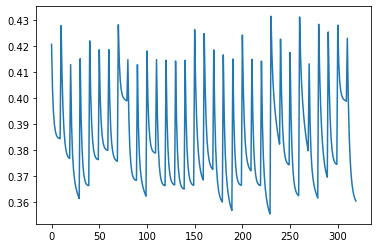

In [9]:
lstm_out, _ = net.lstm(inp)
output = net.hidden2output(lstm_out)
output.shape
out = torch.dstack([F.softplus(output[:,:,0]), torch.tanh(output[:,:,1])*np.pi, output[:,:,2]])
out.shape
plt.plot(torch.flatten(out[:,:,0]).detach().numpy())
F.softplus(output[:,:,0]).shape

In [10]:
outp[:,-1].shape

torch.Size([32, 3])

In [11]:
outp_trace = bicycle_model_eval(outp[:,-1], inp[:,-1])
from viz_net import make_dot

In [12]:
other_outp = net.predict(inp)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
loss = custom_loss_func(outp_trace, other_outp)

In [ ]:
loss.item()

In [ ]:
fig, ax = plt.subplots(figsize=(7,7), dpi=150);
ax.set_aspect(1.0, adjustable='box');
ax.set_title("TEST");
ax.plot(outp_trace[0,:,0].detach().numpy(), outp_trace[0,:,1].detach().numpy(), marker='o', label='Predicted');
ax.plot(target[0,:,0].detach().numpy(), target[0,:,1].detach().numpy(), marker='o', label='Target');
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(7,7), dpi=150);
ax.set_aspect(1.0, adjustable='box');
ax.set_title("TEST");
ax.plot(outp_trace[0,:,0].detach().numpy(), outp_trace[0,:,1].detach().numpy(), marker='o', label='Predicted')
ax.plot(target[0,:10,0].detach().numpy(), target[0,:10,1].detach().numpy(), marker='o', label='Target')
ax.legend()

In [13]:
loss = nn.MSELoss()
loss(outp_trace,torch.tensor(train_frame.iloc[0]['target'], dtype=torch.float32))

/home/nandan/.local/share/virtualenvs/ModelInformedRL-v_iDpmFY/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([80, 3])) that is different to the input size (torch.Size([32, 80, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(667.8295, grad_fn=<MseLossBackward0>)

In [14]:
# Training Loop
torch.autograd.set_detect_anomaly(True)
net = LSTMPredictorBicycle()
net.to(DEVICE)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
train_losses = list()
test_losses = list()
BATCH_SIZE = 32

for epoch in range(100):
    cum_train_loss = 0.0
    net.train()
    i=0
    for input_data, target_data in tqdm(train_dataloader):
        net.zero_grad()
        input_data = input_data.to(DEVICE)
        outp = net.predict(input_data)
        target_data = target_data.squeeze()
        loss = custom_loss_func(outp, target_data.to(DEVICE))
        loss.backward()
        optimizer.step()
        cum_train_loss += loss.item()
    
    train_fig, train_ax = plt.subplots(figsize=(7,7), dpi=150)
    train_ax.set_aspect(1.0, adjustable='box')
    train_ax.set_title(f"Epoch {epoch} training plot | Loss:{loss.item()}")
    train_ax.plot(outp[0,:,0].detach().cpu().numpy(), outp[0,:,1].detach().cpu().numpy(), marker='o', label="Predicted")
    train_ax.plot(target_data[0,:,0].detach().cpu().numpy(), target_data[0,:,1].detach().cpu().numpy(), marker='o', label="Truth")
    train_ax.legend()
    cum_train_loss /= len(train_dataset)
    train_losses.append(cum_train_loss)
    print(cum_train_loss)
    cum_test_loss = 0.0
    net.eval()
    with torch.no_grad():
        for input_data, target_data in tqdm(test_dataloader):
            input_data = input_data.to(DEVICE)
            outp = net.predict(input_data)
            target_data = target_data
            loss = custom_loss_func(outp, target_data.to(DEVICE))
            cum_test_loss += loss.item()
        test_fig, test_ax = plt.subplots(figsize=(7,7), dpi=150)
        test_ax.set_aspect(1.0, adjustable='box')
        test_ax.set_title(f"Epoch {epoch} testing plot | Loss:{loss.item()}")
        test_ax.plot(outp[0,:,0].detach().cpu().numpy(), outp[0,:,1].detach().cpu().numpy(), marker='o', label="Predicted")
        test_ax.plot(target_data[0,:,0].detach().cpu().numpy(), target_data[0,:,1].detach().cpu().numpy(), marker='o', label="Truth")
        test_ax.legend()
    cum_test_loss /= len(test_dataset)
    test_losses.append(cum_test_loss)
    if cum_test_loss <= min(test_losses):
        torch.save(net.state_dict(), "best_simple_bicycle_2.pt")
    print(cum_test_loss)
    writer.add_scalar("train/loss", cum_train_loss, epoch)
    writer.add_scalar("test/loss", cum_test_loss, epoch)
    writer.add_figure("train/example_fig", train_fig, epoch)
    writer.add_figure("test/example_fig", test_fig, epoch)
    print(f"Epoch {epoch} | Train Loss: {cum_train_loss} | Test Loss: {cum_test_loss}")

100%|██████████| 80/80 [00:59<00:00,  1.34it/s]


0.11913399707010519


100%|██████████| 20/20 [00:00<00:00, 48.60it/s]


0.016819671544961317
Epoch 0 | Train Loss: 0.11913399707010519 | Test Loss: 0.016819671544961317


100%|██████████| 80/80 [01:00<00:00,  1.33it/s]


0.01269397613703736


100%|██████████| 20/20 [00:00<00:00, 47.45it/s]


0.012734155312437838
Epoch 1 | Train Loss: 0.01269397613703736 | Test Loss: 0.012734155312437838


100%|██████████| 80/80 [00:59<00:00,  1.35it/s]


0.011333377473934923


100%|██████████| 20/20 [00:00<00:00, 47.95it/s]


0.012197130773467959
Epoch 2 | Train Loss: 0.011333377473934923 | Test Loss: 0.012197130773467959


100%|██████████| 80/80 [00:59<00:00,  1.35it/s]


0.011055009132075423


100%|██████████| 20/20 [00:00<00:00, 46.38it/s]


0.011985049025978736
Epoch 3 | Train Loss: 0.011055009132075423 | Test Loss: 0.011985049025978736


100%|██████████| 80/80 [00:59<00:00,  1.34it/s]


0.011029391476310461


100%|██████████| 20/20 [00:00<00:00, 47.19it/s]


0.011847663384217482
Epoch 4 | Train Loss: 0.011029391476310461 | Test Loss: 0.011847663384217482


100%|██████████| 80/80 [00:59<00:00,  1.33it/s]


0.010744087421481714


100%|██████████| 20/20 [00:00<00:00, 48.22it/s]


0.011631755114443823
Epoch 5 | Train Loss: 0.010744087421481714 | Test Loss: 0.011631755114443823


100%|██████████| 80/80 [00:58<00:00,  1.37it/s]


0.010626796953696406


100%|██████████| 20/20 [00:00<00:00, 49.29it/s]


0.011410609361374958
Epoch 6 | Train Loss: 0.010626796953696406 | Test Loss: 0.011410609361374958


100%|██████████| 80/80 [00:58<00:00,  1.36it/s]


0.010374813151703972


100%|██████████| 20/20 [00:00<00:00, 48.89it/s]


0.011112258779806095
Epoch 7 | Train Loss: 0.010374813151703972 | Test Loss: 0.011112258779806095


100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


0.010255957381805675


100%|██████████| 20/20 [00:00<00:00, 49.01it/s]


0.011090849132936453
Epoch 8 | Train Loss: 0.010255957381805675 | Test Loss: 0.011090849132936453


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.0102484814614737


100%|██████████| 20/20 [00:00<00:00, 46.90it/s]


0.01098307915721995
Epoch 9 | Train Loss: 0.0102484814614737 | Test Loss: 0.01098307915721995


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.00999074556378636


100%|██████████| 20/20 [00:00<00:00, 49.20it/s]


0.010720906957539508
Epoch 10 | Train Loss: 0.00999074556378636 | Test Loss: 0.010720906957539508


100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


0.009880807275631986


100%|██████████| 20/20 [00:00<00:00, 49.07it/s]


0.010512487141172778
Epoch 11 | Train Loss: 0.009880807275631986 | Test Loss: 0.010512487141172778


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.0098573568609467


100%|██████████| 20/20 [00:00<00:00, 49.02it/s]


0.010466660848077463
Epoch 12 | Train Loss: 0.0098573568609467 | Test Loss: 0.010466660848077463


100%|██████████| 80/80 [00:56<00:00,  1.41it/s]


0.009842359129216452


100%|██████████| 20/20 [00:00<00:00, 50.58it/s]


0.010479368345469845
Epoch 13 | Train Loss: 0.009842359129216452 | Test Loss: 0.010479368345469845


100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


0.00975368607133252


100%|██████████| 20/20 [00:00<00:00, 46.11it/s]


0.010226057871614746
Epoch 14 | Train Loss: 0.00975368607133252 | Test Loss: 0.010226057871614746


100%|██████████| 80/80 [01:01<00:00,  1.30it/s]


0.009686967759955464


100%|██████████| 20/20 [00:00<00:00, 49.39it/s]


0.010138267525464437
Epoch 15 | Train Loss: 0.009686967759955464 | Test Loss: 0.010138267525464437


100%|██████████| 80/80 [01:00<00:00,  1.32it/s]


0.009560815636332164


100%|██████████| 20/20 [00:00<00:00, 49.06it/s]


0.01015530300313487
Epoch 16 | Train Loss: 0.009560815636332164 | Test Loss: 0.01015530300313487


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.009550738993317544


100%|██████████| 20/20 [00:00<00:00, 50.28it/s]


0.01002579896449107
Epoch 17 | Train Loss: 0.009550738993317544 | Test Loss: 0.01002579896449107


100%|██████████| 80/80 [00:58<00:00,  1.36it/s]


0.009612179447680056


100%|██████████| 20/20 [00:00<00:00, 48.76it/s]


0.009952749907853465
Epoch 18 | Train Loss: 0.009612179447680056 | Test Loss: 0.009952749907853465


100%|██████████| 80/80 [00:58<00:00,  1.37it/s]


0.00952079342663546


100%|██████████| 20/20 [00:00<00:00, 49.62it/s]


0.009864736453657808
Epoch 19 | Train Loss: 0.00952079342663546 | Test Loss: 0.009864736453657808


100%|██████████| 80/80 [00:58<00:00,  1.36it/s]


0.009297927276307495


100%|██████████| 20/20 [00:00<00:00, 49.46it/s]


0.009947554703971467
Epoch 20 | Train Loss: 0.009297927276307495 | Test Loss: 0.009947554703971467


100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


0.009221392540911318


100%|██████████| 20/20 [00:00<00:00, 48.17it/s]


0.00961368801759401
Epoch 21 | Train Loss: 0.009221392540911318 | Test Loss: 0.00961368801759401


100%|██████████| 80/80 [00:59<00:00,  1.35it/s]


0.009190173685673694


100%|██████████| 20/20 [00:00<00:00, 50.05it/s]


0.009555062293725635
Epoch 22 | Train Loss: 0.009190173685673694 | Test Loss: 0.009555062293725635


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.0091773343386726


100%|██████████| 20/20 [00:00<00:00, 49.01it/s]


0.009639715188105403
Epoch 23 | Train Loss: 0.0091773343386726 | Test Loss: 0.009639715188105403


100%|██████████| 80/80 [00:56<00:00,  1.40it/s]


0.009076916201204155


100%|██████████| 20/20 [00:00<00:00, 49.59it/s]


0.009453732011550262
Epoch 24 | Train Loss: 0.009076916201204155 | Test Loss: 0.009453732011550262


100%|██████████| 80/80 [00:56<00:00,  1.41it/s]


0.009141229210954465


100%|██████████| 20/20 [00:00<00:00, 50.51it/s]


0.009517595119294791
Epoch 25 | Train Loss: 0.009141229210954465 | Test Loss: 0.009517595119294791


100%|██████████| 80/80 [00:56<00:00,  1.41it/s]


0.009063849886059292


100%|██████████| 20/20 [00:00<00:00, 50.08it/s]


0.009505452731480965
Epoch 26 | Train Loss: 0.009063849886059292 | Test Loss: 0.009505452731480965


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.008971632177847784


100%|██████████| 20/20 [00:00<00:00, 50.00it/s]


0.009585802716727909
Epoch 27 | Train Loss: 0.008971632177847784 | Test Loss: 0.009585802716727909


100%|██████████| 80/80 [00:56<00:00,  1.41it/s]


0.009107893876842686


100%|██████████| 20/20 [00:00<00:00, 50.24it/s]


0.009269989980165401
Epoch 28 | Train Loss: 0.009107893876842686 | Test Loss: 0.009269989980165401


100%|██████████| 80/80 [00:56<00:00,  1.40it/s]


0.008966072030517759


100%|██████████| 20/20 [00:00<00:00, 49.44it/s]


0.00941812675124622
Epoch 29 | Train Loss: 0.008966072030517759 | Test Loss: 0.00941812675124622


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.008955922277216689


100%|██████████| 20/20 [00:00<00:00, 49.24it/s]


0.00928014168863768
Epoch 30 | Train Loss: 0.008955922277216689 | Test Loss: 0.00928014168863768


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.008991874783715737


100%|██████████| 20/20 [00:00<00:00, 49.04it/s]


0.009192533726735242
Epoch 31 | Train Loss: 0.008991874783715737 | Test Loss: 0.009192533726735242


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.008987402022119213


100%|██████████| 20/20 [00:00<00:00, 49.49it/s]


0.009778878576995066
Epoch 32 | Train Loss: 0.008987402022119213 | Test Loss: 0.009778878576995066


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.008970190909304569


100%|██████████| 20/20 [00:00<00:00, 49.64it/s]


0.009258852221855376
Epoch 33 | Train Loss: 0.008970190909304569 | Test Loss: 0.009258852221855376


100%|██████████| 80/80 [00:56<00:00,  1.41it/s]


0.00885386758852961


100%|██████████| 20/20 [00:00<00:00, 50.10it/s]


0.009125251518898706
Epoch 34 | Train Loss: 0.00885386758852961 | Test Loss: 0.009125251518898706


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.008924231808866907


100%|██████████| 20/20 [00:00<00:00, 49.00it/s]


0.00969323153304904
Epoch 35 | Train Loss: 0.008924231808866907 | Test Loss: 0.00969323153304904


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.008902855975254666


100%|██████████| 20/20 [00:00<00:00, 48.90it/s]


0.009129228462206325
Epoch 36 | Train Loss: 0.008902855975254666 | Test Loss: 0.009129228462206325


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.008761919329803929


100%|██████████| 20/20 [00:00<00:00, 49.17it/s]


0.009061646260309444
Epoch 37 | Train Loss: 0.008761919329803929 | Test Loss: 0.009061646260309444


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.008735082483463833


100%|██████████| 20/20 [00:00<00:00, 50.83it/s]


0.009215587583404133
Epoch 38 | Train Loss: 0.008735082483463833 | Test Loss: 0.009215587583404133


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.008847920986261429


100%|██████████| 20/20 [00:00<00:00, 49.47it/s]


0.009160790741560598
Epoch 39 | Train Loss: 0.008847920986261429 | Test Loss: 0.009160790741560598


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.00872388542717639


100%|██████████| 20/20 [00:00<00:00, 48.18it/s]


0.00902988935939184
Epoch 40 | Train Loss: 0.00872388542717639 | Test Loss: 0.00902988935939184


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.008810780520709056


100%|██████████| 20/20 [00:00<00:00, 46.28it/s]


0.00895837183275627
Epoch 41 | Train Loss: 0.008810780520709056 | Test Loss: 0.00895837183275627


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.008650380673630853


100%|██████████| 20/20 [00:00<00:00, 49.33it/s]


0.009013892524236787
Epoch 42 | Train Loss: 0.008650380673630853 | Test Loss: 0.009013892524236787


100%|██████████| 80/80 [00:56<00:00,  1.41it/s]


0.008678938095229414


100%|██████████| 20/20 [00:00<00:00, 50.78it/s]


0.008951599693607124
Epoch 43 | Train Loss: 0.008678938095229414 | Test Loss: 0.008951599693607124


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.008723706007003784


100%|██████████| 20/20 [00:00<00:00, 49.02it/s]


0.008706223009098643
Epoch 44 | Train Loss: 0.008723706007003784 | Test Loss: 0.008706223009098643


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.008448351807189438


100%|██████████| 20/20 [00:00<00:00, 49.60it/s]


0.008785679252172003
Epoch 45 | Train Loss: 0.008448351807189438 | Test Loss: 0.008785679252172003


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.008403157992522765


100%|██████████| 20/20 [00:00<00:00, 47.86it/s]


0.008406289126519318
Epoch 46 | Train Loss: 0.008403157992522765 | Test Loss: 0.008406289126519318


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.008429661062223918


100%|██████████| 20/20 [00:00<00:00, 48.70it/s]


0.00879758720109283
Epoch 47 | Train Loss: 0.008429661062223918 | Test Loss: 0.00879758720109283


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.008354983926580855


100%|██████████| 20/20 [00:00<00:00, 48.51it/s]


0.008593820824961835
Epoch 48 | Train Loss: 0.008354983926580855 | Test Loss: 0.008593820824961835


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.008181412234234641


100%|██████████| 20/20 [00:00<00:00, 49.98it/s]


0.008280814272970009
Epoch 49 | Train Loss: 0.008181412234234641 | Test Loss: 0.008280814272970009


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.00822842085833585


100%|██████████| 20/20 [00:00<00:00, 49.26it/s]


0.008268566831384948
Epoch 50 | Train Loss: 0.00822842085833585 | Test Loss: 0.008268566831384948


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.008309970454623302


100%|██████████| 20/20 [00:00<00:00, 49.43it/s]


0.008572627361893093
Epoch 51 | Train Loss: 0.008309970454623302 | Test Loss: 0.008572627361893093


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.008264340842494144


100%|██████████| 20/20 [00:00<00:00, 49.96it/s]


0.008560622043708804
Epoch 52 | Train Loss: 0.008264340842494144 | Test Loss: 0.008560622043708804


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.008075771299805844


100%|██████████| 20/20 [00:00<00:00, 49.02it/s]


0.008033224844974663
Epoch 53 | Train Loss: 0.008075771299805844 | Test Loss: 0.008033224844974663


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.00830479071742076


100%|██████████| 20/20 [00:00<00:00, 49.32it/s]


0.008315509433742594
Epoch 54 | Train Loss: 0.00830479071742076 | Test Loss: 0.008315509433742594


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.008126031131477756


100%|██████████| 20/20 [00:00<00:00, 49.76it/s]


0.008153047175782628
Epoch 55 | Train Loss: 0.008126031131477756 | Test Loss: 0.008153047175782628


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.00791469711148467


100%|██████████| 20/20 [00:00<00:00, 49.29it/s]


0.008216009207736566
Epoch 56 | Train Loss: 0.00791469711148467 | Test Loss: 0.008216009207736566


100%|██████████| 80/80 [00:56<00:00,  1.40it/s]


0.007836831819980681


100%|██████████| 20/20 [00:00<00:00, 50.22it/s]


0.008048120877315148
Epoch 57 | Train Loss: 0.007836831819980681 | Test Loss: 0.008048120877315148


100%|██████████| 80/80 [00:56<00:00,  1.41it/s]


0.007982677689302454


100%|██████████| 20/20 [00:00<00:00, 50.56it/s]


0.008007360420524606
Epoch 58 | Train Loss: 0.007982677689302454 | Test Loss: 0.008007360420524606


100%|██████████| 80/80 [00:56<00:00,  1.41it/s]


0.007754732176673206


100%|██████████| 20/20 [00:00<00:00, 47.95it/s]


0.007851325531067616
Epoch 59 | Train Loss: 0.007754732176673206 | Test Loss: 0.007851325531067616


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.007869912805650735


100%|██████████| 20/20 [00:00<00:00, 49.79it/s]


0.007977196312212682
Epoch 60 | Train Loss: 0.007869912805650735 | Test Loss: 0.007977196312212682


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.007765665348712941


100%|██████████| 20/20 [00:00<00:00, 48.86it/s]


0.007694522480318086
Epoch 61 | Train Loss: 0.007765665348712941 | Test Loss: 0.007694522480318086


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.007644828156357244


100%|██████████| 20/20 [00:00<00:00, 49.65it/s]


0.007816801423695249
Epoch 62 | Train Loss: 0.007644828156357244 | Test Loss: 0.007816801423695249


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.00783215508043602


100%|██████████| 20/20 [00:00<00:00, 48.97it/s]


0.007643400219209153
Epoch 63 | Train Loss: 0.00783215508043602 | Test Loss: 0.007643400219209153


100%|██████████| 80/80 [00:56<00:00,  1.41it/s]


0.00781717561053569


100%|██████████| 20/20 [00:00<00:00, 50.29it/s]


0.007827948632663236
Epoch 64 | Train Loss: 0.00781717561053569 | Test Loss: 0.007827948632663236


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.007553936873340054


100%|██████████| 20/20 [00:00<00:00, 48.60it/s]


0.007513984549480667
Epoch 65 | Train Loss: 0.007553936873340054 | Test Loss: 0.007513984549480667


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.007797326731536561


100%|██████████| 20/20 [00:00<00:00, 49.27it/s]


0.008018394572487805
Epoch 66 | Train Loss: 0.007797326731536561 | Test Loss: 0.008018394572487805


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.007495399332406152


100%|██████████| 20/20 [00:00<00:00, 50.10it/s]


0.00782419093175436
Epoch 67 | Train Loss: 0.007495399332406152 | Test Loss: 0.00782419093175436


100%|██████████| 80/80 [00:56<00:00,  1.41it/s]


0.007567353649855644


100%|██████████| 20/20 [00:00<00:00, 50.42it/s]


0.008236250186593417
Epoch 68 | Train Loss: 0.007567353649855644 | Test Loss: 0.008236250186593417


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.0074995651448719535


100%|██████████| 20/20 [00:00<00:00, 50.12it/s]


0.008278467802088152
Epoch 69 | Train Loss: 0.0074995651448719535 | Test Loss: 0.008278467802088152


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.007585981825612626


100%|██████████| 20/20 [00:00<00:00, 49.89it/s]


0.008107372979213903
Epoch 70 | Train Loss: 0.007585981825612626 | Test Loss: 0.008107372979213903


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.007536724461652573


100%|██████████| 20/20 [00:00<00:00, 49.41it/s]


0.007993284308788727
Epoch 71 | Train Loss: 0.007536724461652573 | Test Loss: 0.007993284308788727


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.007505866941269605


100%|██████████| 20/20 [00:00<00:00, 49.69it/s]


0.007728160252236122
Epoch 72 | Train Loss: 0.007505866941269605 | Test Loss: 0.007728160252236122


100%|██████████| 80/80 [00:56<00:00,  1.40it/s]


0.007272745829673027


100%|██████████| 20/20 [00:00<00:00, 50.55it/s]


0.007145096122446576
Epoch 73 | Train Loss: 0.007272745829673027 | Test Loss: 0.007145096122446576


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.007310768136163037


100%|██████████| 20/20 [00:00<00:00, 50.13it/s]


0.007525648047425309
Epoch 74 | Train Loss: 0.007310768136163037 | Test Loss: 0.007525648047425309


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.007332462092580379


100%|██████████| 20/20 [00:00<00:00, 49.26it/s]


0.007714365204003767
Epoch 75 | Train Loss: 0.007332462092580379 | Test Loss: 0.007714365204003767


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.007559596405675014


100%|██████████| 20/20 [00:00<00:00, 49.05it/s]


0.008945536406438803
Epoch 76 | Train Loss: 0.007559596405675014 | Test Loss: 0.008945536406438803


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.007479306925439609


100%|██████████| 20/20 [00:00<00:00, 50.31it/s]


0.0074166118999244275
Epoch 77 | Train Loss: 0.007479306925439609 | Test Loss: 0.0074166118999244275


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.007602900882403852


100%|██████████| 20/20 [00:00<00:00, 48.71it/s]


0.007514370789567193
Epoch 78 | Train Loss: 0.007602900882403852 | Test Loss: 0.007514370789567193


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


0.007322927928857693


100%|██████████| 20/20 [00:00<00:00, 47.59it/s]


0.006771249272619349
Epoch 79 | Train Loss: 0.007322927928857693 | Test Loss: 0.006771249272619349


100%|██████████| 80/80 [00:56<00:00,  1.41it/s]


0.006995205292273195


100%|██████████| 20/20 [00:00<00:00, 50.55it/s]


0.008189596750391897
Epoch 80 | Train Loss: 0.006995205292273195 | Test Loss: 0.008189596750391897


100%|██████████| 80/80 [00:56<00:00,  1.41it/s]


0.007501336361527584


100%|██████████| 20/20 [00:00<00:00, 49.75it/s]


0.009310719222298222
Epoch 81 | Train Loss: 0.007501336361527584 | Test Loss: 0.009310719222298222


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.007629700021894426


100%|██████████| 20/20 [00:00<00:00, 49.69it/s]


0.007877481235790665
Epoch 82 | Train Loss: 0.007629700021894426 | Test Loss: 0.007877481235790665


100%|██████████| 80/80 [00:56<00:00,  1.40it/s]


0.007198597722593109


100%|██████████| 20/20 [00:00<00:00, 50.69it/s]


0.007614089310566896
Epoch 83 | Train Loss: 0.007198597722593109 | Test Loss: 0.007614089310566896


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]


0.00697492551843419


100%|██████████| 20/20 [00:00<00:00, 50.36it/s]


0.006885997085500175
Epoch 84 | Train Loss: 0.00697492551843419 | Test Loss: 0.006885997085500175


100%|██████████| 80/80 [01:00<00:00,  1.31it/s]


0.006841550070833438


100%|██████████| 20/20 [00:00<00:00, 45.50it/s]


0.007836694564535816
Epoch 85 | Train Loss: 0.006841550070833438 | Test Loss: 0.007836694564535816


100%|██████████| 80/80 [00:59<00:00,  1.34it/s]


0.006654417519340491


100%|██████████| 20/20 [00:00<00:00, 45.76it/s]


0.00682665791883012
Epoch 86 | Train Loss: 0.006654417519340491 | Test Loss: 0.00682665791883012


100%|██████████| 80/80 [00:59<00:00,  1.34it/s]


0.006885056126183309


100%|██████████| 20/20 [00:00<00:00, 46.28it/s]


0.007081541658219775
Epoch 87 | Train Loss: 0.006885056126183309 | Test Loss: 0.007081541658219775


100%|██████████| 80/80 [00:59<00:00,  1.34it/s]


0.00681254019193445


100%|██████████| 20/20 [00:00<00:00, 49.29it/s]


0.00683810227087098
Epoch 88 | Train Loss: 0.00681254019193445 | Test Loss: 0.00683810227087098


100%|██████████| 80/80 [00:59<00:00,  1.34it/s]


0.006819761093887471


100%|██████████| 20/20 [00:00<00:00, 46.55it/s]


0.006861410037946289
Epoch 89 | Train Loss: 0.006819761093887471 | Test Loss: 0.006861410037946289


100%|██████████| 80/80 [00:58<00:00,  1.37it/s]


0.006994415602482762


100%|██████████| 20/20 [00:00<00:00, 47.70it/s]


0.006540408995429426
Epoch 90 | Train Loss: 0.006994415602482762 | Test Loss: 0.006540408995429426


100%|██████████| 80/80 [01:00<00:00,  1.32it/s]


0.006853971816672586


100%|██████████| 20/20 [00:00<00:00, 50.36it/s]


0.007432605898712456
Epoch 91 | Train Loss: 0.006853971816672586 | Test Loss: 0.007432605898712456


100%|██████████| 80/80 [00:58<00:00,  1.37it/s]


0.007040395810702265


100%|██████████| 20/20 [00:00<00:00, 47.55it/s]


0.0067871620197264325
Epoch 92 | Train Loss: 0.007040395810702265 | Test Loss: 0.0067871620197264325


100%|██████████| 80/80 [00:58<00:00,  1.36it/s]


0.0069515889572014785


100%|██████████| 20/20 [00:00<00:00, 48.24it/s]


0.0068929906747358
Epoch 93 | Train Loss: 0.0069515889572014785 | Test Loss: 0.0068929906747358


100%|██████████| 80/80 [00:59<00:00,  1.35it/s]


0.00679767927676205


100%|██████████| 20/20 [00:00<00:00, 50.32it/s]


0.0064718464339733875
Epoch 94 | Train Loss: 0.00679767927676205 | Test Loss: 0.0064718464339733875


100%|██████████| 80/80 [01:01<00:00,  1.31it/s]


0.00675839946587693


100%|██████████| 20/20 [00:00<00:00, 48.72it/s]


0.006979607506194613
Epoch 95 | Train Loss: 0.00675839946587693 | Test Loss: 0.006979607506194613


100%|██████████| 80/80 [01:00<00:00,  1.33it/s]


0.006552215183077603


100%|██████████| 20/20 [00:00<00:00, 50.92it/s]


0.0072971815491911
Epoch 96 | Train Loss: 0.006552215183077603 | Test Loss: 0.0072971815491911


100%|██████████| 80/80 [01:00<00:00,  1.33it/s]


0.0068927942160165534


100%|██████████| 20/20 [00:00<00:00, 42.54it/s]


0.007104969432861127
Epoch 97 | Train Loss: 0.0068927942160165534 | Test Loss: 0.007104969432861127


100%|██████████| 80/80 [00:58<00:00,  1.37it/s]


0.006637310656812628


100%|██████████| 20/20 [00:00<00:00, 46.68it/s]


0.007111725700051294
Epoch 98 | Train Loss: 0.006637310656812628 | Test Loss: 0.007111725700051294


100%|██████████| 80/80 [01:00<00:00,  1.33it/s]


0.006871418739704169


100%|██████████| 20/20 [00:00<00:00, 50.31it/s]


0.006731963834872987
Epoch 99 | Train Loss: 0.006871418739704169 | Test Loss: 0.006731963834872987


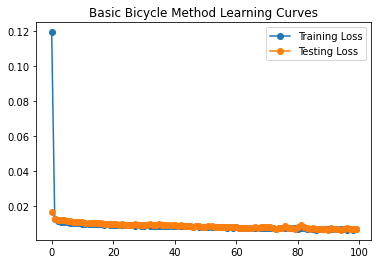

In [15]:
plt.title(f"Basic Bicycle Method Learning Curves")
plt.plot(train_losses, marker='o', label="Training Loss")
plt.plot(test_losses, marker='o', label="Testing Loss")
plt.legend()
plt.savefig("basic_learning_batched.png")

In [ ]:
test_losses

In [ ]:
pytorch_total_params = sum(p.numel() for p in net.parameters())
pytorch_total_params